# Test GEModelTools - HANK

This notebook shows how to **solve a simple Heterogenous Agent New Keynessian (HANK) model** using the `GEModelTools` package.

**The steps of the sequence-space solution method are:**

1. Find the stationary equilibrium (steady state for aggregates and distribution).
2. Compute Jacobians of the household block and the full model (to unknowns and shocks)
3. Find the non-linear transition path or the linearized impulse responses to a given shock path.
4. Simulate the linearized model with aggregate risk

# Imports

In [ ]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from HANKModel import HANKModelClass

# Setup

In [267]:
model = HANKModelClass(name='baseline')
#print(model)

# Step 1: Steady state

In [269]:
model.find_ss(do_print=True)

1.2 0.8 0.9875 0.8
1.2 0.8 0.9875 0.8
1.2 0.8 0.9875 0.8
1.2000000178813934 0.8 0.9875 0.8
1.2 0.800000011920929 0.9875 0.8
1.2 0.8 0.9875000147148967 0.8
0.9033471843325732 0.6038861093838876 0.9856733588652593 0.8
0.8614669698347782 0.5764800405293175 0.9853769077266497 0.8
0.8543717884493321 0.5717606548647257 0.9853281531958019 0.8
0.8541053678140511 0.5715838100595525 0.9853269299515574 0.8
0.8540781515526165 0.5715658004381912 0.9853268759955083 0.8
0.8540731375904783 0.5715624839175846 0.9853268665408091 0.8
0.8540730858115052 0.5715624496476066 0.9853268664431385 0.8
0.854073085811433 0.5715624496479739 0.9853268664431386 0.8
0.854073085811433 0.5715624496479739 0.9853268664431386 0.8
steady state found in 9.7 secs
 par.M_N   =   0.8541
 par.M_L   =   0.5716
 par.varphi   =   0.8000
 par.beta   =   0.9853

Discrepancy in B =  -0.00000000
Discrepancy in C =   0.00000000
Discrepancy in N =   0.00000000


In [265]:
model.solve_hh_ss(do_print=True)

household problem in ss solved in 0.3 secs [489 iterations]


In [266]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

## Policy functions

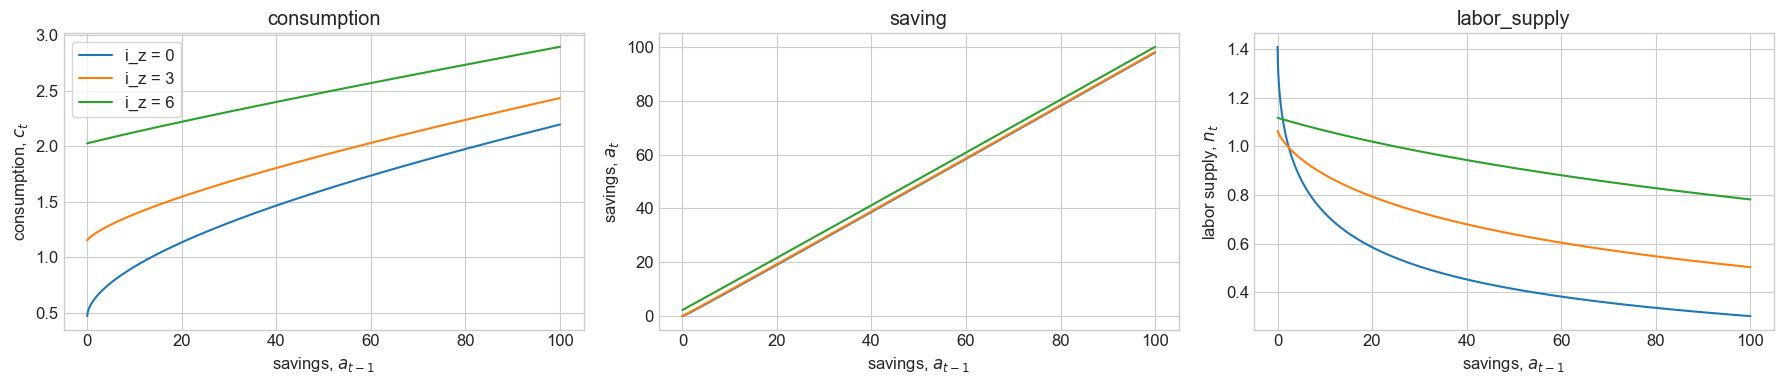

In [261]:
fig = plt.figure(figsize=(18,4),dpi=100)
a_max = 500

# a. consumption
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,1)
ax.set_title(f'consumption')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c[0,i_z,I],label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,2)
ax.set_title(f'saving')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.a[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

# c. labor supply
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,3)
ax.set_title(f'labor_supply')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.ell[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $n_{t}$')

fig.tight_layout()

In [263]:
print("Steady state wage = ", ss.w_L, ss.w_N)
print("Steady state B, G, A, A_HH, tau = ", ss.B, ss.G, ss.A, ss.A_hh, ss.tau)
print("Steady state interest rate", ss.r)
print("steady state consumption", ss.C_hh)
print("Steady state laborsupply ell ", ss.ell)
print("varphi= ", par.varphi, "beta = ", par.beta)

Steady state wage =  0.7389817346930883 0.6232618422973919
Steady state B, G, A, A_HH, tau =  5.6 0.0 5.6 5.600000000000044 0.0
Steady state interest rate 0.0
steady state consumption 1.2627772705205147
Steady state laborsupply ell  [[[1.40824621 1.40386654 1.39944748 ... 0.30640852 0.30463119 0.30285964]
  [1.27525062 1.27232967 1.26938004 ... 0.36482251 0.36282618 0.36083444]
  [1.15516979 1.15322135 1.15125261 ... 0.43220197 0.42999613 0.42779294]
  ...
  [1.04824974 1.04819815 1.04814594 ... 0.59437492 0.59185014 0.58932169]
  [1.07214676 1.0721198  1.07209253 ... 0.6877596  0.68516521 0.6825632 ]
  [1.11677218 1.11675465 1.11673691 ... 0.78690442 0.78432078 0.7817254 ]]]
varphi=  0.8 beta =  0.9853268664431386


## Simulation

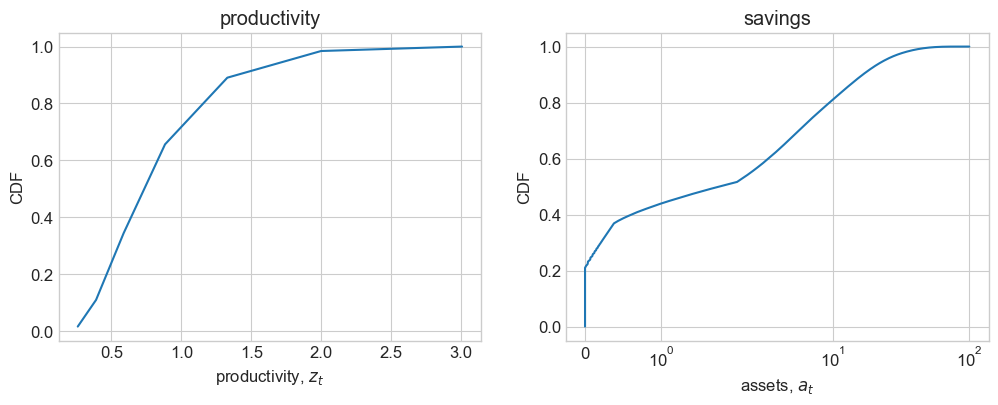

In [264]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')

y = np.cumsum(np.sum(ss.D[0],axis=1))
ax.plot(par.z_grid,y/y[-1])

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
y = np.insert(np.cumsum(np.sum(ss.D[0],axis=0)),0,0.0)
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
        
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')


# Step 2: Compute Jacobians (incl. tests)

**Household transition path:**

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 0.5 secs
household problem simulated along transition in 1.8 secs



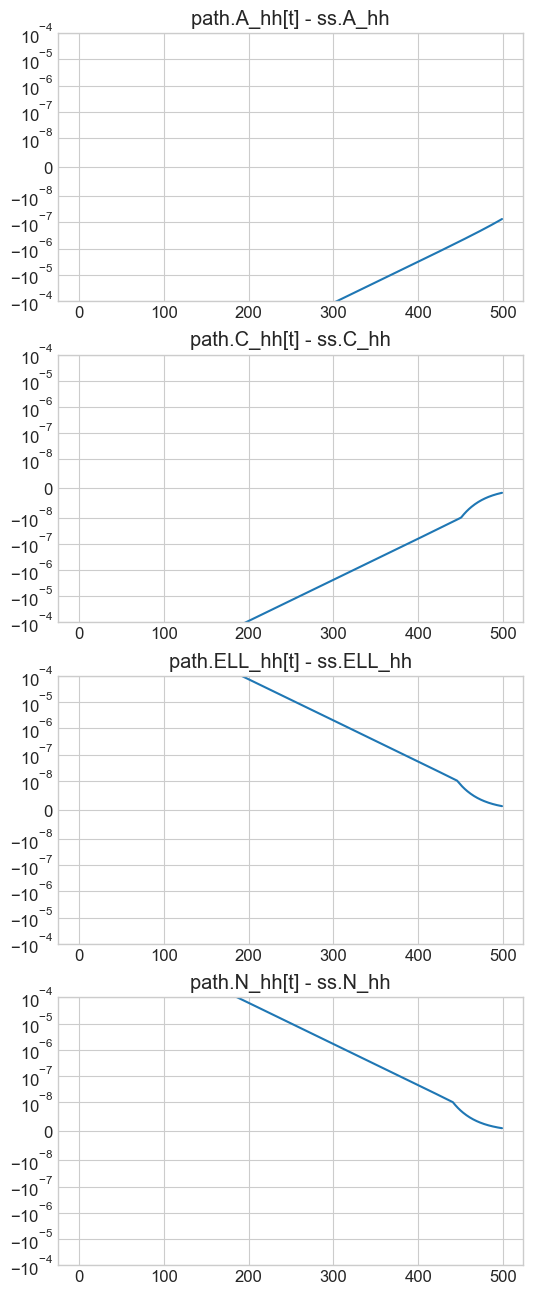

In [238]:
model.test_hh_path()

**Full transition path:**

In [239]:
model.test_path()

note: inputs = steady state value -> expected: no difference to steady state and zero errors



TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mUnknown attribute 'd' of type PathClass(array(float64, 4d, C), array(float64, 4d, C), array(float64, 4d, C), array(float64, 4d, C), array(float64, 4d, C), array(float64, 4d, C), array(float64, 3d, C), array(float64, 4d, C), array(float64, 4d, C), array(int32, 4d, C), array(float64, 4d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C))
[1m
File "blocks.py", line 22:[0m
[1mdef block_pre(par,ini,ss,path,ncols=1):
    <source elided>
        clearing_N = path.clearing_N[ncol,:]
[1m        d = path.d[ncol,:]
[0m        [1m^[0m[0m
[0m
[0m[1mDuring: typing of get attribute at c:\Users\Johan\OneDrive\Økonomi KU\Speciale\GitHub Repositories\hank_speciale_backup\One sector fuck migashauhfausdhfadsf\HANK copy\blocks.py (22)[0m
[1m
File "blocks.py", line 22:[0m
[1mdef block_pre(par,ini,ss,path,ncols=1):
    <source elided>
        clearing_N = path.clearing_N[ncol,:]
[1m        d = path.d[ncol,:]
[0m        [1m^[0m[0m


note: differences should only be due to numerical errors

direct method:
finding Jacobian wrt. ghost          : 50 100 150 [computed in 0.6 secs]
finding Jacobian wrt. d_L            : 50 100 150 [computed in 0.6 secs]
finding Jacobian wrt. d_N            : 50 100 150 [computed in 0.7 secs]
finding Jacobian wrt. r              : 50 100 150 [computed in 0.6 secs]
finding Jacobian wrt. tau            : 50 100 150 [computed in 0.7 secs]
finding Jacobian wrt. w_L            : 50 100 150 [computed in 0.6 secs]
finding Jacobian wrt. w_N            : 50 100 150 [computed in 0.6 secs]
household Jacobian computed in 4.8 secs

fake news method:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for d_L             in 0.4 secs
curly_Y and curly_D calculated for d_N             in 0.4 secs
curly_Y and curly_D calculated for r               in 0.4 secs
curly_Y and curly_D calculated for tau             in 0.4 secs
curly_Y and curly_D calculated for w_L       

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mUnknown attribute 'd' of type PathClass(array(float64, 4d, C), array(float64, 4d, C), array(float64, 4d, C), array(float64, 4d, C), array(float64, 4d, C), array(float64, 4d, C), array(float64, 3d, C), array(float64, 4d, C), array(float64, 4d, C), array(int32, 4d, C), array(float64, 4d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C))
[1m
File "blocks.py", line 22:[0m
[1mdef block_pre(par,ini,ss,path,ncols=1):
    <source elided>
        clearing_N = path.clearing_N[ncol,:]
[1m        d = path.d[ncol,:]
[0m        [1m^[0m[0m
[0m
[0m[1mDuring: typing of get attribute at c:\Users\Johan\OneDrive\Økonomi KU\Speciale\GitHub Repositories\hank_speciale_backup\One sector fuck migashauhfausdhfadsf\HANK copy\blocks.py (22)[0m
[1m
File "blocks.py", line 22:[0m
[1mdef block_pre(par,ini,ss,path,ncols=1):
    <source elided>
        clearing_N = path.clearing_N[ncol,:]
[1m        d = path.d[ncol,:]
[0m        [1m^[0m[0m


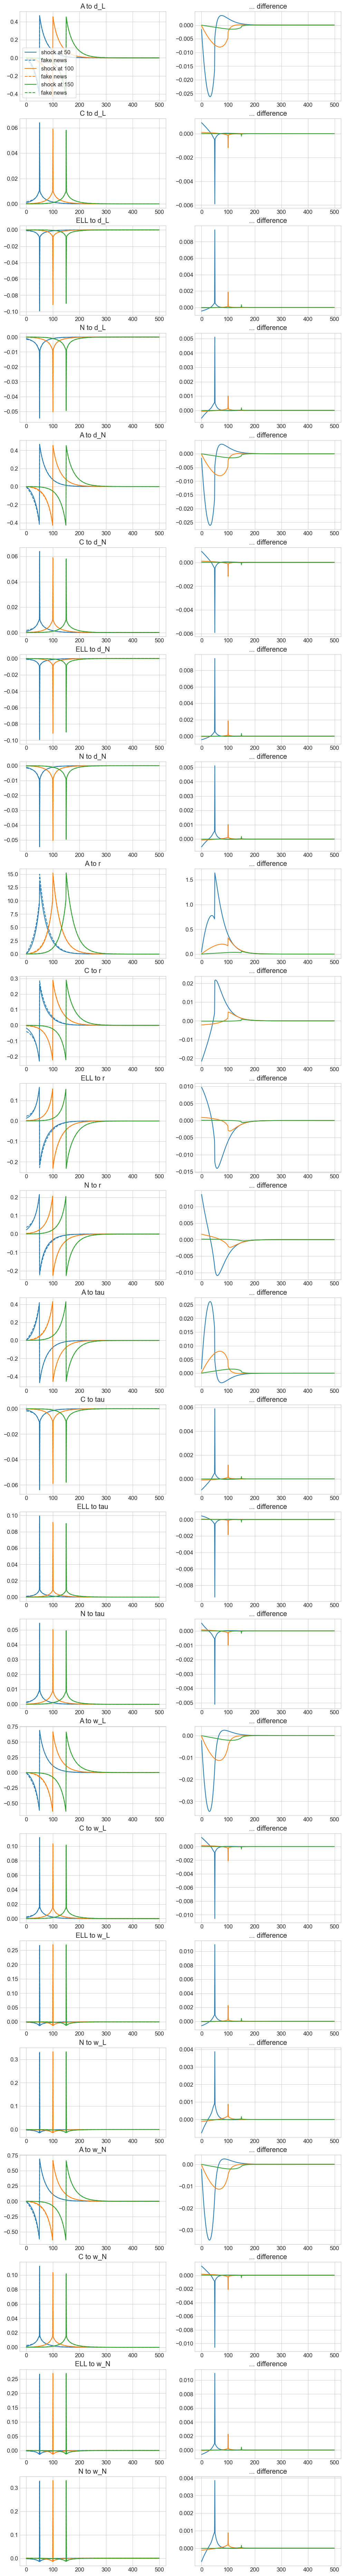

In [240]:
model.test_jacs(s_list=[50,100,150])

# Step 3a: Find non-linear transition path

## Find transition path

In [241]:
par.jump_istar = -0.10/4
model.find_transition_path(do_print=True)

finding the transition path:


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mUnknown attribute 'd' of type PathClass(array(float64, 4d, C), array(float64, 4d, C), array(float64, 4d, C), array(float64, 4d, C), array(float64, 4d, C), array(float64, 4d, C), array(float64, 3d, C), array(float64, 4d, C), array(float64, 4d, C), array(int32, 4d, C), array(float64, 4d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C))
[1m
File "blocks.py", line 22:[0m
[1mdef block_pre(par,ini,ss,path,ncols=1):
    <source elided>
        clearing_N = path.clearing_N[ncol,:]
[1m        d = path.d[ncol,:]
[0m        [1m^[0m[0m
[0m
[0m[1mDuring: typing of get attribute at c:\Users\Johan\OneDrive\Økonomi KU\Speciale\GitHub Repositories\hank_speciale_backup\One sector fuck migashauhfausdhfadsf\HANK copy\blocks.py (22)[0m
[1m
File "blocks.py", line 22:[0m
[1mdef block_pre(par,ini,ss,path,ncols=1):
    <source elided>
        clearing_N = path.clearing_N[ncol,:]
[1m        d = path.d[ncol,:]
[0m        [1m^[0m[0m


## Plot transitions

### shocks ###


c:\users\johan\onedrive\økonomi ku\speciale\github repositories\numeconcopenhagen\gemodeltools\GEModelTools\figures.py:109: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(np.arange(T_max),100*(pathvalue[:T_max]/ssvalue-1),label=label)


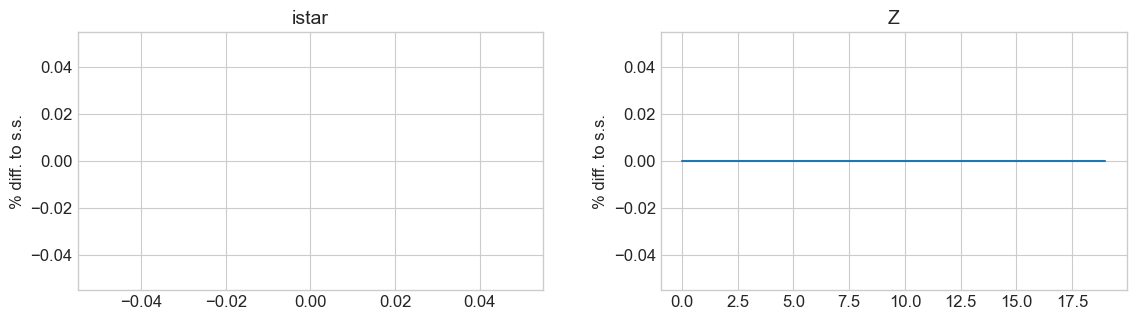


### varnames ###


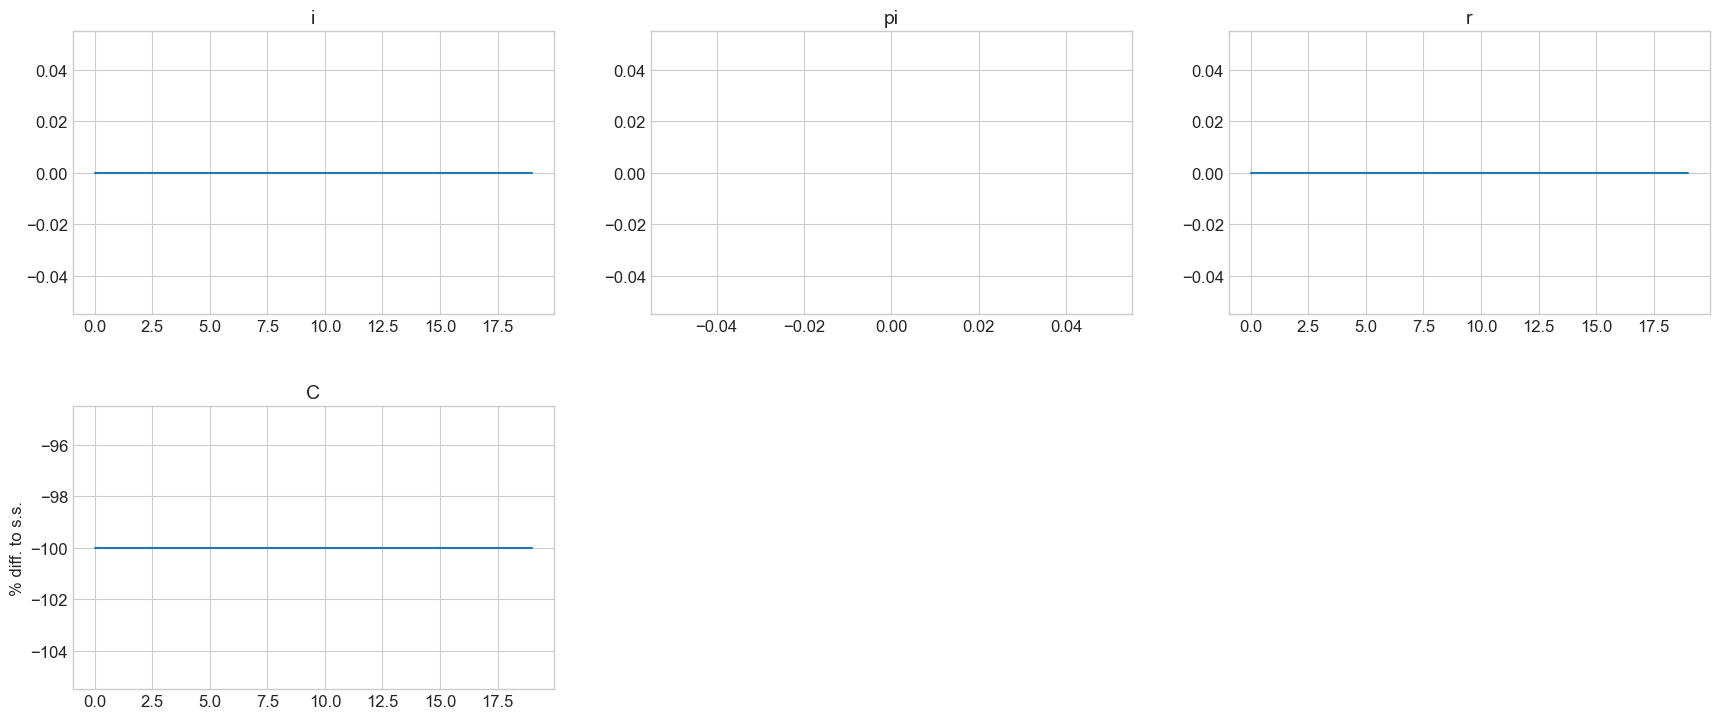


### tagets ###


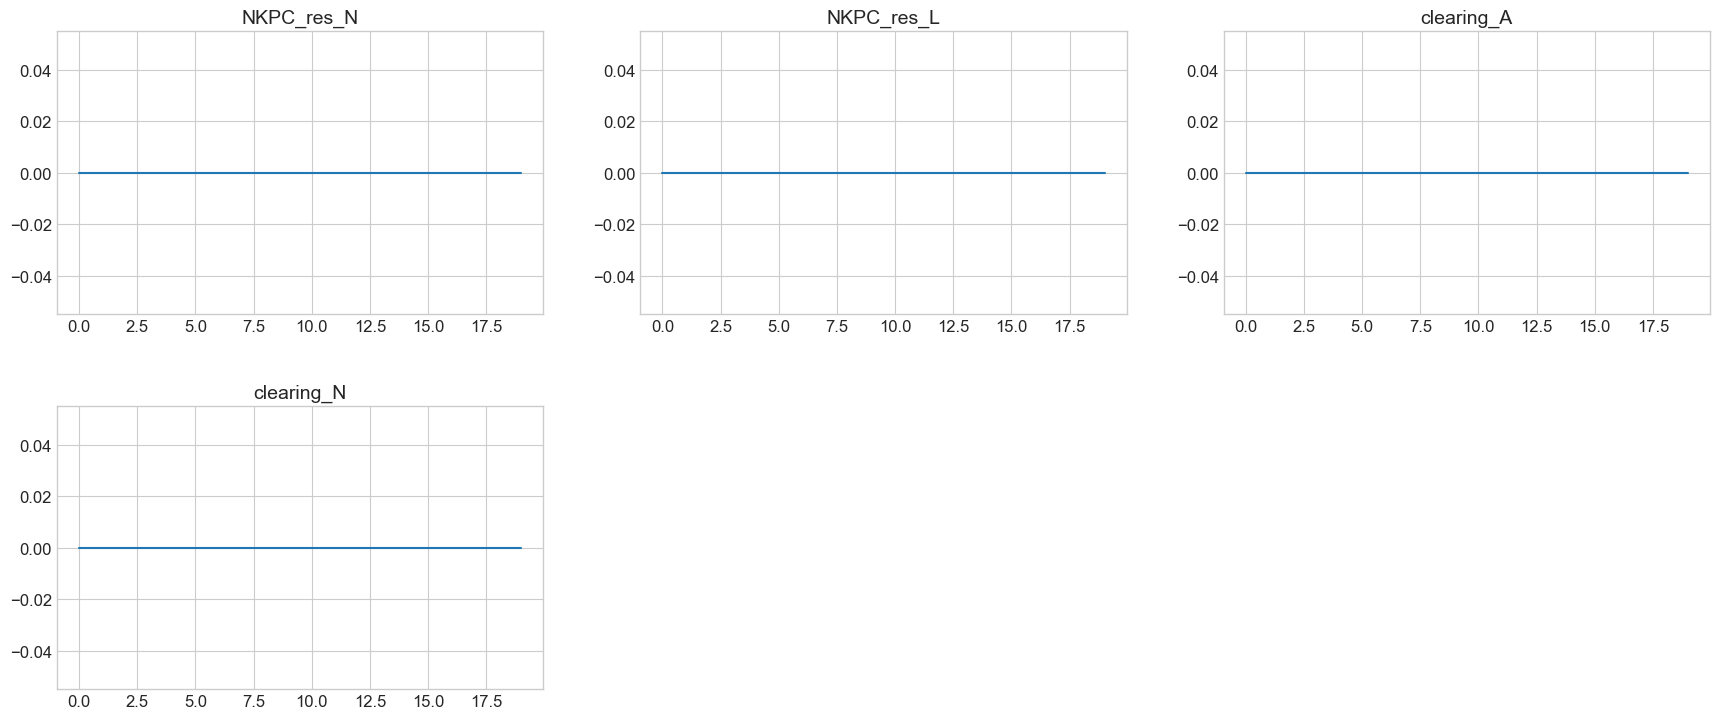

In [242]:
paths = ['i','pi','r','C']
lvl_value = ['i','pi','r']
model.show_IRFs(paths,lvl_value=lvl_value,T_max=20,ncols=3)

# Step 3b: Find linearized IRFs

In [243]:
model.find_IRFs(do_print=True)

LinAlgError: Last 2 dimensions of the array must be square

### shocks ###


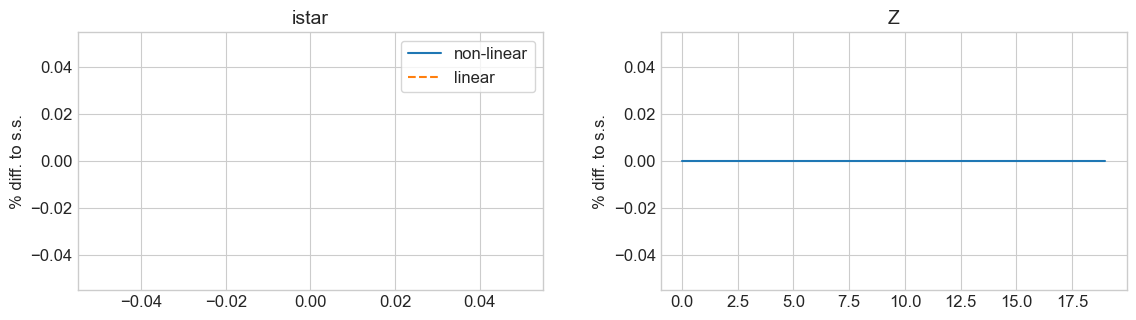


### varnames ###


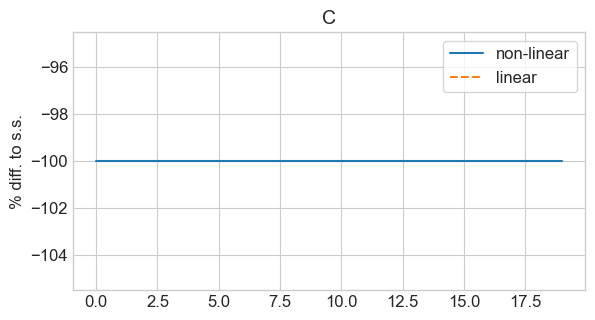


### tagets ###


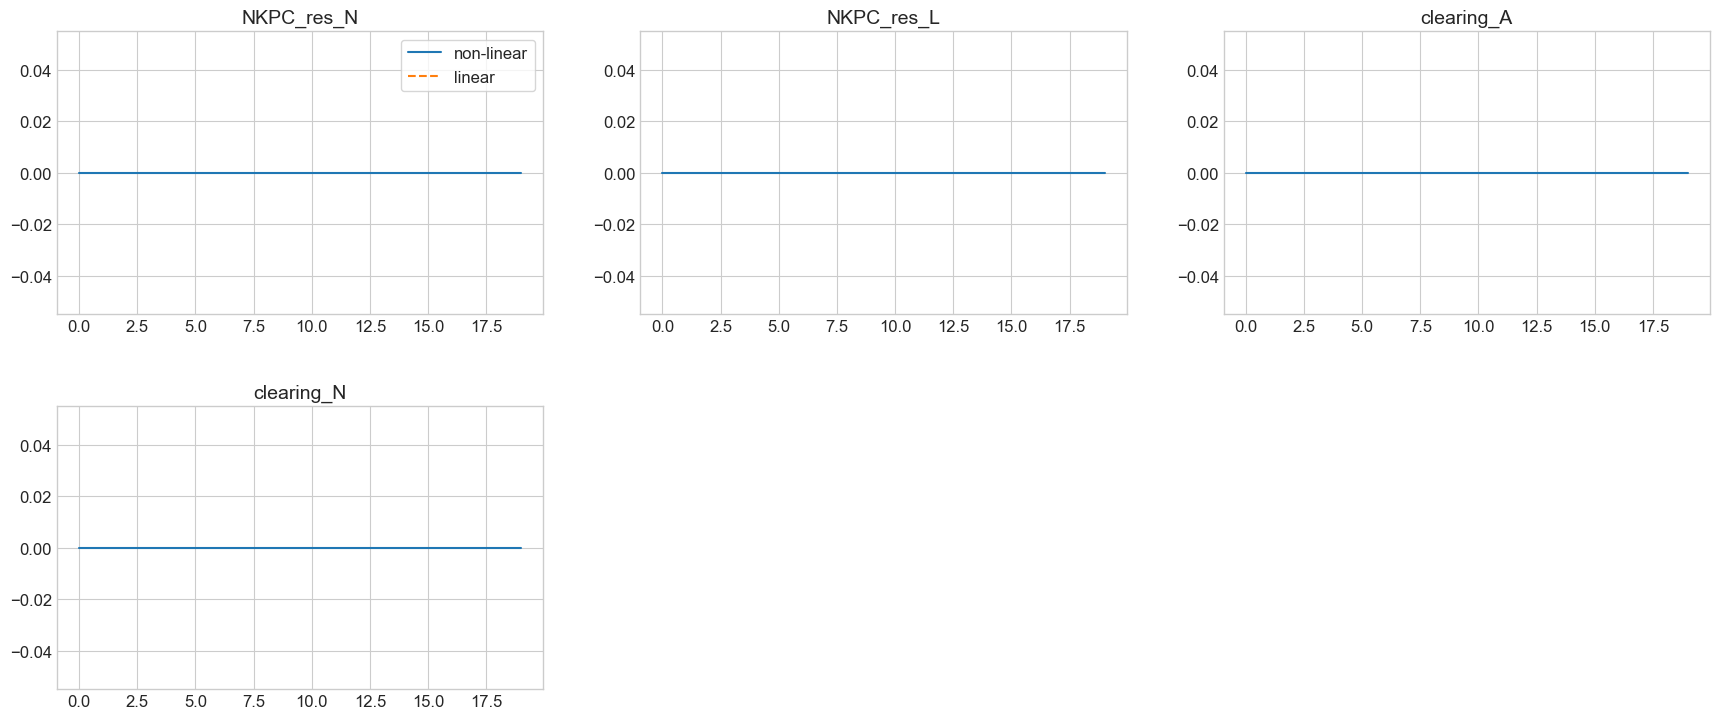

In [244]:
paths = ['C']
model.show_IRFs(paths,T_max=20,ncols=3,do_linear=True)

# Step 4. Simulation

In [245]:
np.random.seed(1917)
model.simulate(do_print=True)

LinAlgError: Last 2 dimensions of the array must be square

In [246]:
def model_sim():
    
    fig = plt.figure(figsize=(12,8),dpi=100)

    ax = fig.add_subplot(2,2,1)
    ax.set_title('i')
    ax.plot(ss.i+sim.di,ls='--')
    ax.axhline(ss.i,color='black',zorder=0)

    ax = fig.add_subplot(2,2,2)
    ax.set_title('pi')
    ax.plot(ss.pi+sim.dpi,ls='--',)
    ax.axhline(ss.pi,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,3)
    ax.set_title('r')
    ax.plot(ss.r+sim.dr,ls='--',)
    ax.axhline(ss.r,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,4)
    ax.set_title('C')
    ax.plot(ss.C+sim.dC,ls='--',)
    ax.axhline(ss.C,color='black',zorder=0)
    

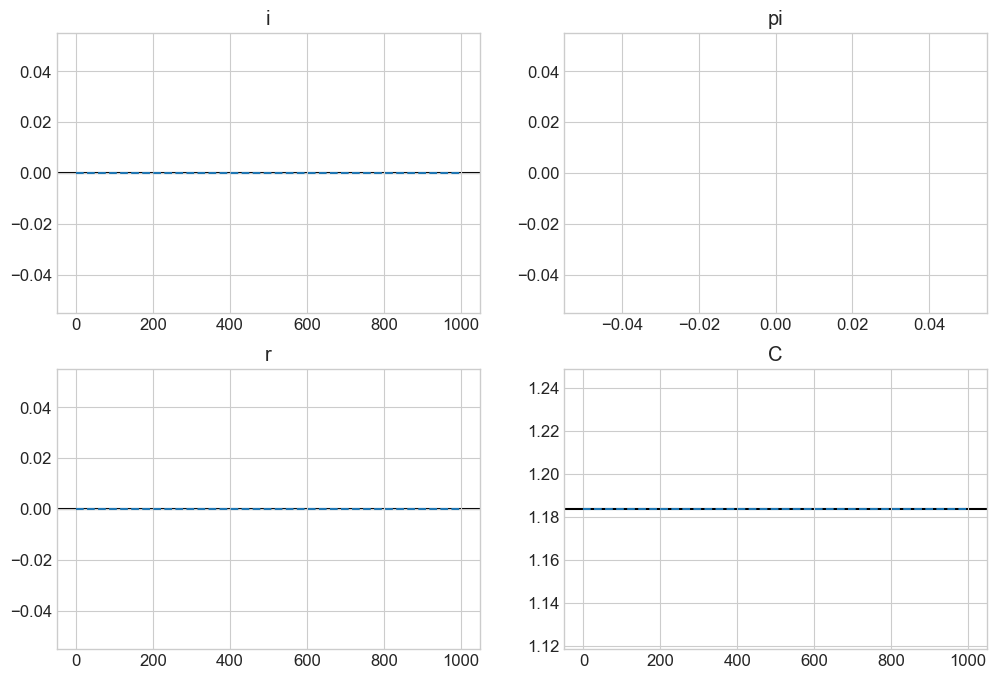

In [247]:
model_sim()